# Learning word embedding with Skip Gram

In this notebook my goal is to play with skipgram to discover sementic relation between word. The dataset used for that is [text8](http://mattmahoney.net/dc/textdata)


To achive that I have divied the task into subprocess:

- **[Preprocessing](#Preprocessing)**:
    The raw text has to be converted into tuples of the form (input, output) where input is the center word an output is the word to be predicted (context word), for example if we have the phase "the cat eat a fish" with a skipgram of size n=2 (window size = 4) we would have as center word eat, and the tupples would be : [(eat, the), (eat, cat), (eat, a), (eat, fish)]
    
- **[Building the model](#Building-the-model)**: The model used here is pretty simple as it contains only of two layers:
    - The first layer (projection layer) is of size [V, D] where V is the vocabulary size and D is the dimention of the word embedded, this is the matrix containing the embedding representation of the center word
    - The second layer (hidden layer) is of size [D,V], we can interpret this layer as an embedding for the context word
    
- **[Training](#Training)**: It took me about 8 hours (on CPU) to train this model for about 100'000 batchs.

- **[Postprocessing](#Postprocessing)**: In this part using some visualization technique my goal is to plot the vector space of words in 2D to see the relation between words. In addition to that I looked at the closest word of some interesting words.

***

## Imports and global variables

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
import math

In [2]:
#global variables
INPUT_FOLDER = "input"
OUTPUT_FOLDER = "output"
LOG_DIR = os.path.join(OUTPUT_FOLDER, "logs")

## Preprocessing

In [3]:
#opening file
file = open(os.path.join(INPUT_FOLDER, "text8"))
words = file.read().split()

In [4]:
#building dictionary of vocabulary:
def buildDictionary(split):
    dic = dict()
    for w in split:
        if w not in dic:
            dic[w] = len(dic)
    return dic

dic = buildDictionary(words)

In [5]:
#Encode the text
enc_words = []

for word in words:
    enc_words.append(dic[word])
print(enc_words[0:10])
print(len(enc_words))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 5, 15, 17, 18, 19, 15, 20, 21, 5, 15, 22, 18, 23, 15, 4, 24, 25, 8, 26, 3, 27, 28, 29, 30, 31, 32, 33, 8, 34, 35, 29, 36, 15, 37, 5, 38, 39, 40, 41, 42, 43, 44, 2, 3, 45, 46, 47, 48, 49, 50, 15, 51, 0, 24, 52, 53, 15, 54, 55, 56, 57, 58, 59, 0, 2, 3, 60, 61, 24, 15, 62, 33, 63, 64, 65, 19, 66, 67, 68, 69, 70, 64, 71]
17005207


In [6]:
inv_dic = {v: k for k, v in dic.items()}
file = open(os.path.join(OUTPUT_FOLDER, "labels.tvs"), "w")
for i in range(len(inv_dic)):
    file.write(inv_dic[i]+"\n")

In [7]:
counter = dict()
for word in enc_words:
    if word in counter:
        counter[word] += 1
    else:
        counter[word] = 1
inv_counter = [(v,k) for k, v in counter.items()]
inv_counter = sorted(inv_counter, key=lambda tup : tup[0], reverse=True)
most_freq = [ w for (f,w) in inv_counter]
most_freq[:10]

[15, 5, 19, 196, 26, 3, 29, 253, 275, 445]

In [8]:
##Subsampling of Frequent Words

def compute_prob_word(word):
    #compute the probability by witch a word has to be discarded
    w = counter[word]/len(words) #frequency of the word
    t = 1e-5 # threshold
    return 1 - math.sqrt(t/w)
subsampled_enc_word = []
for word in enc_words:
    if random.uniform(0, 1.0) >= compute_prob_word(word):
        subsampled_enc_word.append(word)

print(len(subsampled_enc_word))
print(len(enc_words))
#enc_words = subsampled_enc_word

4978332
17005207


In [9]:
center_word = 0

#this function compute the next batch to feed to the NN
def generate_next_batch(batch_size, window_size):
    global center_word
    #window_size is the number of word to look left and right of the center word
    assert batch_size % window_size == 0 #per center word we generate num_skip tupple
    assert window_size % 2 == 0
    if center_word < window_size//2 or center_word > (len(enc_words) - window_size//2):
        center_word = window_size//2
    
    X = np.ndarray(shape=(batch_size), dtype=np.int32)
    y = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    for i in range(batch_size // window_size):
        for j in range(window_size):
            j_ = j//2
            X[i*window_size + j] = enc_words[center_word]
            if j % 2 == 0:
                y[i*window_size + j, 0] = enc_words[center_word + j_ + 1]
            else:
                y[i*window_size + j, 0] = enc_words[center_word - j_ - 1]
        #TODO print when we enter a new epoch
        center_word = center_word + 1 % (len(enc_words) - window_size//2)
    return X, y
        
    

## Building the model

In [10]:
graph = tf.Graph()
#size of the vocabulary
voc_dim = len(dic)
#dimention of the word vector
word_dim = 50

with graph.as_default(), tf.device('/cpu:0'):
    #input tensor 
    x_pl = tf.placeholder(tf.int32, [None])
    #input label
    y_pl = tf.placeholder(tf.float32, [None])

    y_pl = tf.expand_dims(y_pl,1)
    
    W_1 = tf.Variable(tf.random_normal([voc_dim, word_dim], stddev=0.35), name="word_embedded")
    #b_1 = tf.Variable(tf.random_normal([1,word_dim], stddev=0.35), name="bias_1")
    
    #y_1 = tf.matmul(x_pl, W_1, name="mult_1") #map a word x to it's embedding y_1
    
    emb = tf.nn.embedding_lookup(W_1, x_pl)

    W_2 = tf.Variable(tf.random_normal([word_dim, voc_dim], stddev=0.35), name="Context_word_embedded") # 1 is the output dim, because we have only one class label either 0 or 1
    b_2 = tf.Variable(tf.random_normal([voc_dim], stddev=0.35), name="bias_2")
    
    #y_2 = tf.matmul(y_1, W_2) + b_2
    #print(y_1)
    W_2 = tf.transpose(W_2)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_pl, logits=y_2))
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=W_2, biases=b_2, inputs=emb,
                               labels=y_pl, num_sampled=64, num_classes=voc_dim))
    learning_rate = 1.0
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)

## Training

In [11]:
number_of_batch = 100000#5000
batch_size = 120
display_step = 100
window_size = 4 #number of word to take into account left and right
training_size = len(enc_words)*window_size #size of the training set
final_embedded = []
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    tf.global_variables_initializer().run()
    avg_cost = 0
    for batch in range(number_of_batch):
        batch_xs, batch_ys = generate_next_batch(batch_size, window_size=window_size)
        # Fit training using batch data
        _, c = sess.run([optimizer, loss], feed_dict={x_pl: batch_xs, y_pl: batch_ys})
        # Compute average loss
        avg_cost += c / display_step
        # Display logs per batch step
        if (batch+1) % display_step == 0:
            print("batch: " + str(batch+1) + " cost= " + str(avg_cost))
            saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), batch)
            avg_cost = 0
            final_embedded = W_1.eval()

    saver.save(sess, os.path.join(LOG_DIR, "final_model.ckpt"), 0)
    final_embedded = W_1.eval()

print("Optimization Finished!")

batch: 100 cost= 8.18176821232
batch: 200 cost= 6.7009393549
batch: 300 cost= 6.06103008509
batch: 400 cost= 5.37985575199
batch: 500 cost= 5.07683894873
batch: 600 cost= 4.72316682339
batch: 700 cost= 5.01580962896
batch: 800 cost= 4.65208146095
batch: 900 cost= 4.47990369797
batch: 1000 cost= 4.57919417858
batch: 1100 cost= 3.94934638262
batch: 1200 cost= 4.47257932305
batch: 1300 cost= 4.38119340658
batch: 1400 cost= 4.2558026886
batch: 1500 cost= 4.49903200865
batch: 1600 cost= 4.27376326323
batch: 1700 cost= 4.19456418991
batch: 1800 cost= 3.98374769747
batch: 1900 cost= 4.1371932894
batch: 2000 cost= 3.77564333379
batch: 2100 cost= 3.73911643267
batch: 2200 cost= 3.53457183659
batch: 2300 cost= 3.77610189915
batch: 2400 cost= 4.22046823263
batch: 2500 cost= 4.2127862668
batch: 2600 cost= 4.13060929298
batch: 2700 cost= 4.16371028185
batch: 2800 cost= 3.83630219698
batch: 2900 cost= 3.9758312726
batch: 3000 cost= 3.80592582703
batch: 3100 cost= 3.91559755087
batch: 3200 cost= 3.74

In [12]:
with tf.Session(graph=graph) as session:
    saver.restore(session,os.path.join(LOG_DIR, "final_model.ckpt-0"))
    final_embedded = W_1.eval()

INFO:tensorflow:Restoring parameters from output/logs/final_model.ckpt-0


## Postprocessing

In [13]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    plt.show()

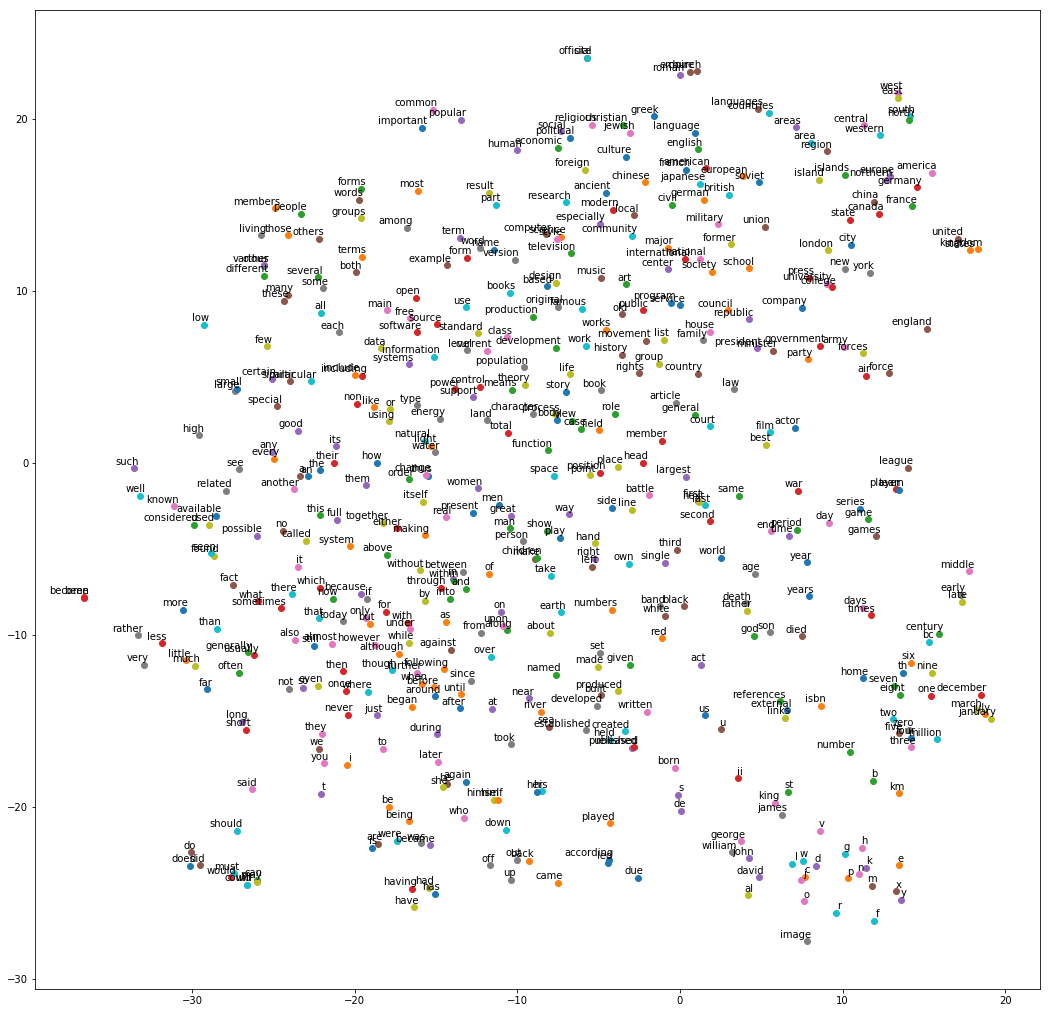

In [17]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only_most_freq = 500
    # plot only the most frequent words
    low_dim_embs = tsne.fit_transform(final_embedded[most_freq[:plot_only_most_freq], :])
    labels = [inv_dic[i] for i in most_freq[:plot_only_most_freq]]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [19]:
def euclidian_squared_dist(v_1, v_2):
    assert len(v_1) == len(v_2)
    v = []
    for i in range(len(v_1)):
        v.append(v_1[i] - v_2[i])
    dist = 0
    for i in range(len(v)):
        dist += v[i]*v[i]
    return dist

def similar_to(word):
    idx = dic[word]
    my_vec = final_embedded[idx]
    dist = []
    for i in range(len(final_embedded)):
        vec = final_embedded[i]
        dist.append((euclidian_squared_dist(vec, my_vec), i))
    sorted_by_dist = sorted(dist, key=lambda tup: tup[0])
    res = []
    i = 0
    j = 0
    while j<10:
        if sorted_by_dist[i][1] in most_freq[0:50000]:
            res.append(inv_dic[sorted_by_dist[i][1]])
            j += 1
        i +=1
    return res

similar_to("school")

#try remove infrequent words
        

['school',
 'conjecture',
 'schools',
 'society',
 'alberta',
 'drought',
 'entry',
 'classics',
 'business',
 'louisiana']